### Creating a Multi Level Perceptron from scratch without using major libraries

#### mlp_pp_02

#### importing standard libraries and loading the dataset

In [1]:
import numpy as np
import pandas as pd
import scipy.io
import matplotlib.pyplot as plt

In [ ]:
#for collab
# train_class0_data = scipy.io.loadmat("/content/train_class0.mat")['x']
# train_class1_data = scipy.io.loadmat("/content/train_class1.mat")['x']
# test_class0_data = scipy.io.loadmat("/content/test_class0.mat")['x']
# test_class1_data = scipy.io.loadmat("/content/test_class1.mat")['x'

train_class0_data = scipy.io.loadmat("C:/Users/tanma/Downloads/data-task1/train_class0.mat")['x']
train_class1_data = scipy.io.loadmat("C:/Users/tanma/Downloads/data-task1/train_class1.mat")['x']
test_class0_data = scipy.io.loadmat("C:/Users/tanma/Downloads/data-task1/test_class0.mat")['x']
test_class1_data = scipy.io.loadmat("C:/Users/tanma/Downloads/data-task1/test_class1.mat")['x']

#### Cleaning/Deconstructing/Fixing the datasets

In [3]:
train_class0_data_csv = pd.DataFrame(train_class0_data)
train_class1_data_csv = pd.DataFrame(train_class1_data)
test_class0_data_csv = pd.DataFrame(test_class0_data)
test_class1_data_csv = pd.DataFrame(test_class1_data)

# Data preparation
train_data_csv = np.vstack((train_class0_data_csv[:1500], train_class1_data_csv[:1500]))
train_labels_csv = np.hstack((np.zeros(1500), np.ones(1500)))

val_data_csv = np.vstack((train_class0_data_csv[1500:], train_class1_data_csv[1500:]))
val_labels_csv = np.hstack((np.zeros(500), np.ones(500)))

test_data_csv = np.vstack((test_class0_data_csv, test_class1_data_csv))
test_labels_csv = np.hstack((np.zeros(1000), np.ones(1000)))

#### Calculating stats for calculations

In [4]:
mean_csv = np.mean(train_data_csv, axis=0)
std_csv = np.std(train_data_csv, axis=0)
train_data_csv = (train_data_csv - mean_csv) / std_csv
val_data_csv = (val_data_csv - mean_csv) / std_csv
test_data_csv = (test_data_csv - mean_csv) / std_csv

#### Defining a class MLP - contains basic functionality of a perceptron

In [5]:
class MLP: #Reference - https://elcaiseri.medium.com/building-a-multi-layer-perceptron-from-scratch-with-numpy-e4cee82ab06d, https://medium.com/@hirok4/building-a-multi-layer-perceptron-from-scratch-c9679752cf48

    def __init__(self, input_size, hidden_size, output_size, learning_rate, beta1=0.9, beta2=0.999, epsilon=1e-8, dropout_rate = 0.2):
        # Initialize weights and biases
        self.W1 = np.random.randn(input_size, hidden_size) * np.sqrt(2 / input_size)
        self.b1 = np.zeros((1, hidden_size))
        self.W2 = np.random.randn(hidden_size, hidden_size) * np.sqrt(2 / hidden_size)
        self.b2 = np.zeros((1, hidden_size))
        self.W3 = np.random.randn(hidden_size, output_size) * np.sqrt(2 / hidden_size)
        self.b3 = np.zeros((1, output_size))

        # Learning rate and Adam parameters
        self.dropout_rate = dropout_rate
        self.learning_rate = learning_rate
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon

        # Initialize Adam moment estimates
        self.mW1, self.vW1 = np.zeros_like(self.W1), np.zeros_like(self.W1)
        self.mb1, self.vb1 = np.zeros_like(self.b1), np.zeros_like(self.b1)
        self.mW2, self.vW2 = np.zeros_like(self.W2), np.zeros_like(self.W2)
        self.mb2, self.vb2 = np.zeros_like(self.b2), np.zeros_like(self.b2)
        self.mW3, self.vW3 = np.zeros_like(self.W3), np.zeros_like(self.W3)
        self.mb3, self.vb3 = np.zeros_like(self.b3), np.zeros_like(self.b3)

        # Time step
        self.t = 0

    #Activation Functions (we will only use one of these)
    def relu(self, x):
        return np.maximum(0, x)

    def relu_derivative(self, x):
        return (x > 0).astype(float)
    
    def leaky_relu(self, x, alpha=0.01):
        return np.where(x > 0, x, alpha * x)

    def leaky_relu_derivative(self, x, alpha=0.01):
        return np.where(x > 0, 1, alpha)
    
    def swish(self, x):
        return x * (1 / (1 + np.exp(-x)))  # x * sigmoid(x)

    def swish_derivative(self, x):
        sigmoid = 1 / (1 + np.exp(-x))
        return sigmoid * (1 + x * (1 - sigmoid))
    
    def dropout(self, x):
        mask = (np.random.rand(*x.shape) > self.dropout_rate).astype(float)
        return x * mask

    def forward(self, x):
        self.z1 = np.dot(x, self.W1) + self.b1
        self.a1 = self.relu(self.z1)
        # self.a1 = self.dropout(self.a1)
        self.z2 = np.dot(self.a1, self.W2) + self.b2
        self.a2 = self.relu(self.z2)
        # self.a2 = self.dropout(self.a2)
        self.z3 = np.dot(self.a2, self.W3) + self.b3
        return self.z3

    def backward(self, x, y, output):
        m = x.shape[0]
        dz3 = (output - y) / m
        dW3 = np.dot(self.a2.T, dz3)
        db3 = np.sum(dz3, axis=0, keepdims=True)

        dz2 = np.dot(dz3, self.W3.T) * self.relu_derivative(self.z2)
        dW2 = np.dot(self.a1.T, dz2)
        db2 = np.sum(dz2, axis=0, keepdims=True)

        dz1 = np.dot(dz2, self.W2.T) * self.relu_derivative(self.z1)
        dW1 = np.dot(x.T, dz1)
        db1 = np.sum(dz1, axis=0, keepdims=True)

        # Update weights and biases using Adam
        self.update_with_adam('W1', dW1)
        self.update_with_adam('b1', db1)
        self.update_with_adam('W2', dW2)
        self.update_with_adam('b2', db2)
        self.update_with_adam('W3', dW3)
        self.update_with_adam('b3', db3)

    def update_with_adam(self, param_name, grad):  #reference - https://medium.com/the-ml-practitioner/how-to-implement-an-adam-optimizer-from-scratch-76e7b217f1cc
        # Increment time step
        self.t += 1

        # Select parameters and moment estimates
        param = getattr(self, param_name)
        m = getattr(self, f'm{param_name}')
        v = getattr(self, f'v{param_name}')

        # Compute moment estimates
        m = self.beta1 * m + (1 - self.beta1) * grad
        v = self.beta2 * v + (1 - self.beta2) * (grad ** 2)

        # Bias correction
        m_hat = m / (1 - self.beta1 ** self.t)
        v_hat = v / (1 - self.beta2 ** self.t)

        # Update parameter
        param -= self.learning_rate * m_hat / (np.sqrt(v_hat) + self.epsilon)

        # Save updated parameters and moment estimates
        setattr(self, param_name, param)
        setattr(self, f'm{param_name}', m)
        setattr(self, f'v{param_name}', v)

    def train(self, x, y, batch_size, epochs=500,  val_data=None, verbose=True):
        history = {'train_loss': [], 'val_loss': []}
        for epoch in range(epochs):
            # print(f"Starting epoch {epoch+1}/{epochs}")
            permutation = np.random.permutation(x.shape[0])
            x_shuffled = x[permutation]
            y_shuffled = y[permutation]

            for i in range(0, x.shape[0], batch_size):
                x_batch = x_shuffled[i:i + batch_size]
                y_batch = y_shuffled[i:i + batch_size]
                output = self.forward(x_batch)
                self.backward(x_batch, y_batch, output)

            train_loss = np.mean((self.forward(x) - y) ** 2)
            history['train_loss'].append(train_loss)
            if val_data:
                val_loss = np.mean((self.forward(val_data[0]) - val_data[1]) ** 2)
                history['val_loss'].append(val_loss)

            if verbose and epoch % 50 == 0:
                print(f"Epoch {epoch}, Train Loss: {train_loss}, Val Loss: {val_loss if val_data else 'N/A'}")

        return history

    def predict(self, x):
        return self.forward(x)


#### Preparing labels

In [ ]:

#Neural networks require numerical inputs and outputs. A one-hot encoded label transforms the categorical output into a vector representation, making it compatible with the model.
train_labels_one_hot = np.eye(2)[train_labels_csv.astype(int)]
val_labels_one_hot = np.eye(2)[val_labels_csv.astype(int)]
test_labels_one_hot = np.eye(2)[test_labels_csv.astype(int)]

# print(train_labels_one_hot)
# print(val_labels_one_hot)
# print(test_labels_one_hot)


results = {}
nH_values = [2, 4, 6, 8, 10] #for comparing different number of hidden nodes

#### Code block for running the perceptron


Training with nH = 2
Epoch 0, Train Loss: 1.8098351478044163, Val Loss: 1.9580664527377316
Epoch 50, Train Loss: 0.41624895995362793, Val Loss: 0.4261950119191122
Epoch 100, Train Loss: 0.2708586113686588, Val Loss: 0.2735754228104805
Epoch 150, Train Loss: 0.2526993091027332, Val Loss: 0.2533407984775485
Epoch 200, Train Loss: 0.24760847491203034, Val Loss: 0.2471577047546453
Epoch 250, Train Loss: 0.23168702257278512, Val Loss: 0.22838890795903777
Epoch 300, Train Loss: 0.2234241441453125, Val Loss: 0.21850444132634195
Epoch 350, Train Loss: 0.22213037591234486, Val Loss: 0.21758636727686778
Epoch 400, Train Loss: 0.2219357835289884, Val Loss: 0.2175906985595225
Epoch 450, Train Loss: 0.22188919540292726, Val Loss: 0.21754647575804664

Training with nH = 4
Epoch 0, Train Loss: 1.2064486509684116, Val Loss: 1.2778688799125832
Epoch 50, Train Loss: 0.250963018971979, Val Loss: 0.24943551355091784
Epoch 100, Train Loss: 0.2109796324483295, Val Loss: 0.20917154240105798
Epoch 150, Train

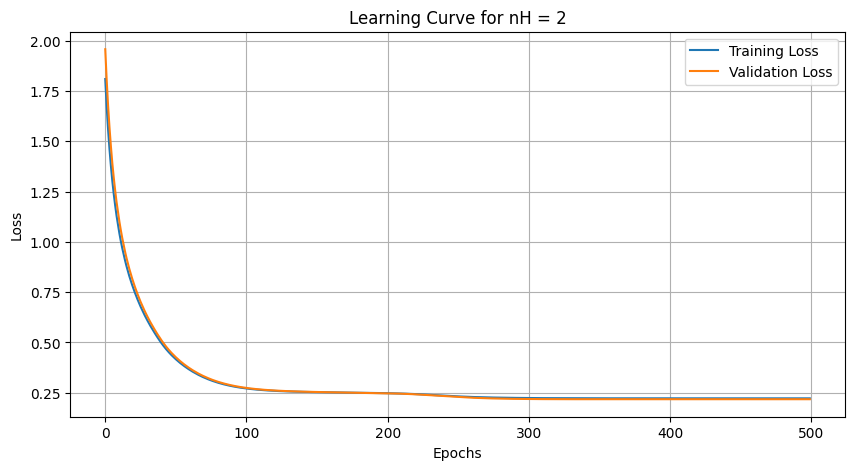

nH = 4, Test Accuracy: 0.7355


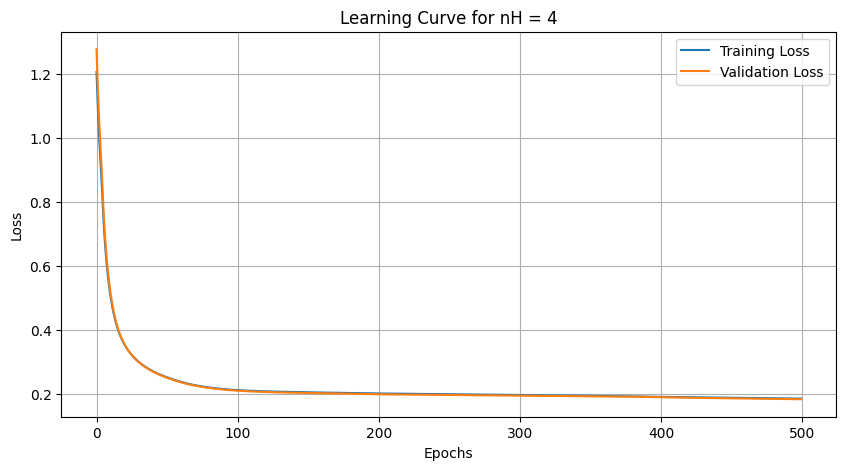

nH = 6, Test Accuracy: 0.8050


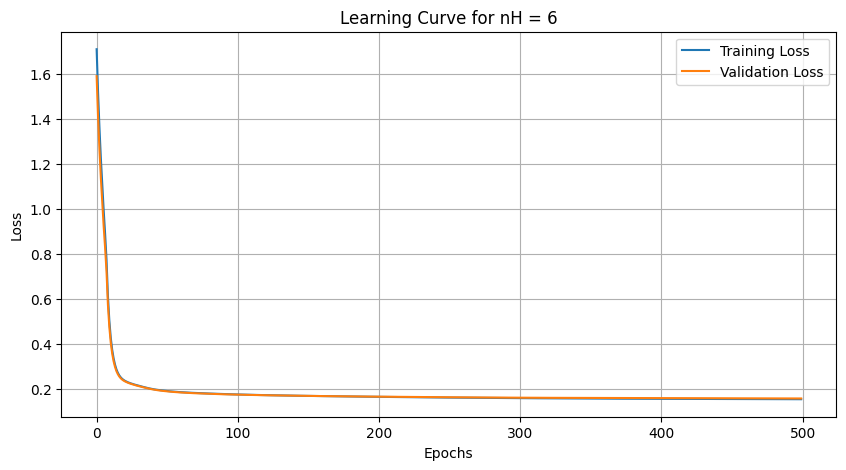

nH = 8, Test Accuracy: 0.8270


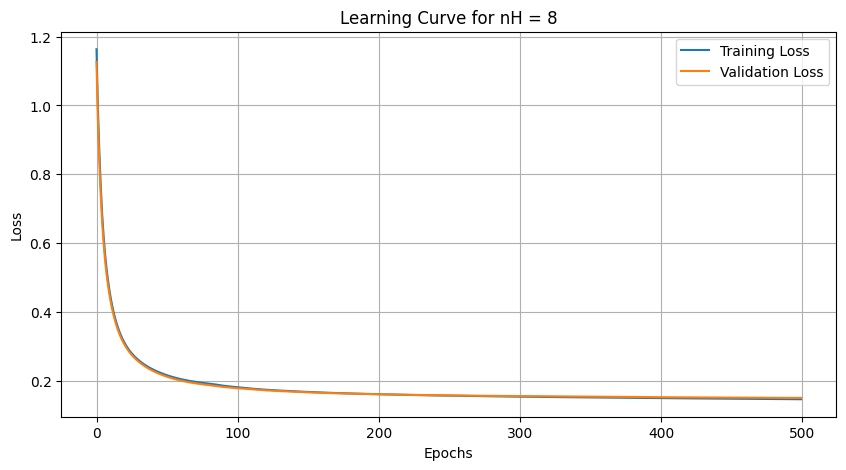

nH = 10, Test Accuracy: 0.8340


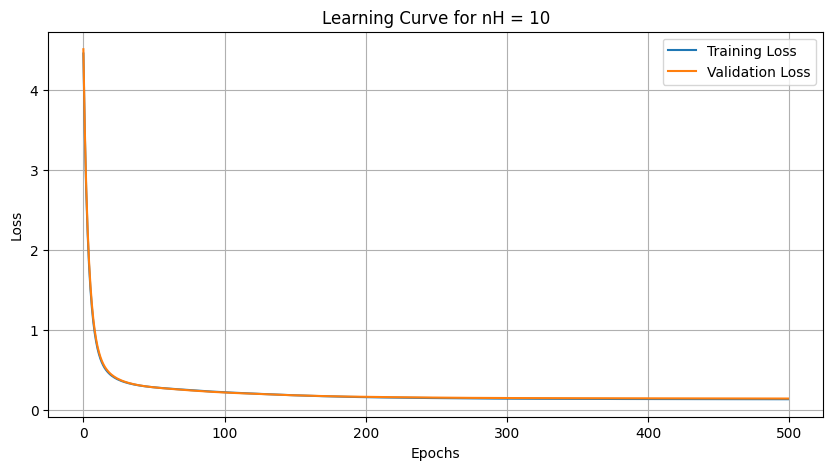

In [7]:
for nH in nH_values:
    print(f"\nTraining with nH = {nH}")
    model = MLP(input_size=2, hidden_size=nH, output_size=2, learning_rate=0.0001)
    history = model.train(train_data_csv, train_labels_one_hot, epochs=500, batch_size=64, val_data=(val_data_csv, val_labels_one_hot))
    test_predictions = model.predict(test_data_csv)
    test_accuracy = np.mean(np.argmax(test_predictions, axis=1) == test_labels_csv)
    results[nH] = {'history': history, 'test_accuracy': test_accuracy}


# Plotting the learning curves and printing accuracies
for nH, result in results.items():
    history = result['history']
    test_accuracy = result['test_accuracy']

    # Print test accuracy
    print(f"nH = {nH}, Test Accuracy: {test_accuracy:.4f}")

    # Plot learning curves
    plt.figure(figsize=(10, 5))
    plt.plot(history['train_loss'], label='Training Loss')
    if 'val_loss' in history:
        plt.plot(history['val_loss'], label='Validation Loss')
    plt.title(f'Learning Curve for nH = {nH}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()